In [31]:
# Import libraries
from pandas import read_csv
from matplotlib import pyplot
from numpy import sqrt
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [3]:
airlines = pd.read_excel('F:\\PYTHON\\DATA SCIENCE\\Forcasting Methods\\Assigments\\Airlines+Data.xlsx')

In [4]:
airlines

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


# Visualization

<AxesSubplot:>

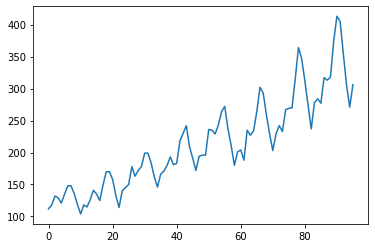

In [5]:
airlines.Passengers.plot()
# can observe upward trend and multiplicative seasonality 

<AxesSubplot:>

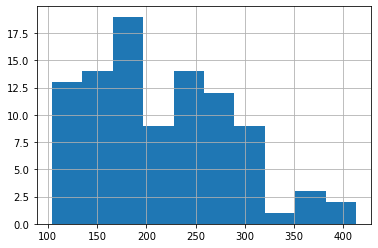

In [6]:
airlines.Passengers.hist()

<AxesSubplot:ylabel='Density'>

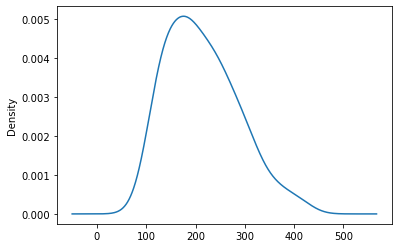

In [7]:
airlines.Passengers.plot(kind='kde')

In [10]:
print(airlines.Passengers.skew())
print(airlines.Passengers.kurt())

0.6373753552984904
-0.12812093729688012


In [11]:
from pandas.plotting import lag_plot

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

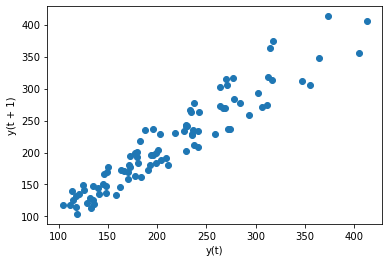

In [12]:
lag_plot(airlines.Passengers , lag=1)
# variable having positive relation with its lagged sample 

# Data Preprocessing

In [22]:
# t value 
airlines['t'] = np.arange(1,97)

In [24]:
# t squared 
airlines['t-squared'] = airlines['t']*airlines['t']

In [26]:
# log of value
airlines['log_value'] = np.log(airlines.Passengers)

In [27]:
airlines["month"] = airlines.Month.dt.strftime('%b')
airlines["year"] = airlines.Month.dt.strftime('%Y')

In [29]:
dummies = pd.get_dummies(airlines['month'])
airlines_new = pd.concat([airlines,dummies],axis=1,)
airlines_new


,Month,Passengers,t,t-squared,log_value,month,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,1,1,4.718499,Jan,1995,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,2,4,4.770685,Feb,1995,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,3,9,4.882802,Mar,1995,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,4,16,4.859812,Apr,1995,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,5,25,4.795791,May,1995,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,92,8464,6.003887,Aug,2002,0,1,0,0,0,0,0,0,0,0,0,0
92,2002-09-01,355,93,8649,5.872118,Sep,2002,0,0,0,0,0,0,0,0,0,0,0,1
93,2002-10-01,306,94,8836,5.723585,Oct,2002,0,0,0,0,0,0,0,0,0,0,1,0
94,2002-11-01,271,95,9025,5.602119,Nov,2002,0,0,0,0,0,0,0,0,0,1,0,0


<AxesSubplot:xlabel='month', ylabel='year'>

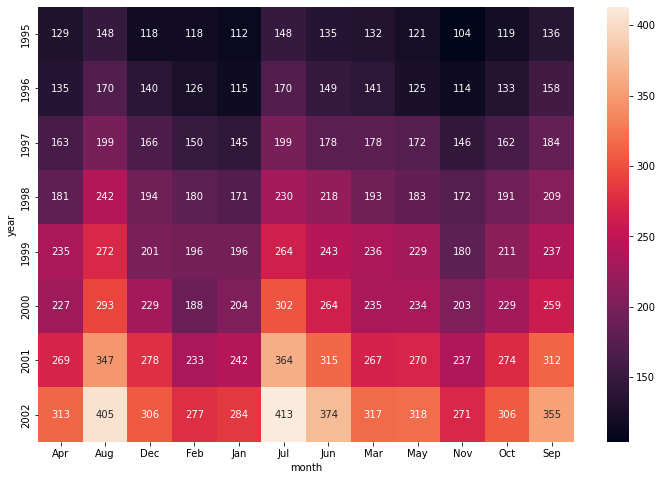

In [32]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=airlines_new,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values

<AxesSubplot:xlabel='year', ylabel='Passengers'>

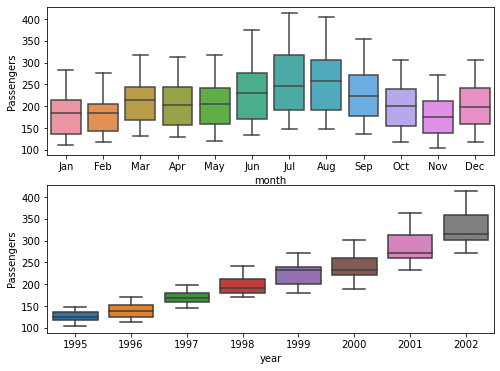

In [33]:
plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x="month",y="Passengers",data=airlines_new)
plt.subplot(212)
sns.boxplot(x="year",y="Passengers",data=airlines_new)
# Box plot 

# Time series decomposition plot

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

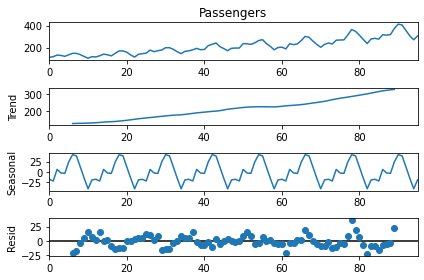

In [44]:
decompose_ts_add = seasonal_decompose(airlines_new.Passengers,period=12)
decompose_ts_add.plot()
plt.show()

In [48]:
from statsmodels.graphics.tsaplots import plot_acf

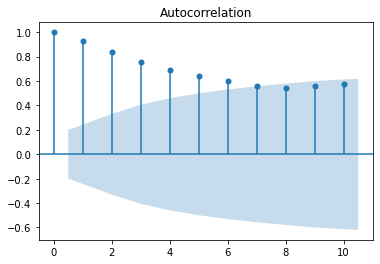

In [49]:
plot_acf(airlines.Passengers,lags=10)
plt.show()
# lags 1 to 6 are above threshold value.
#Plot defining magnitude of relation with its lagged value

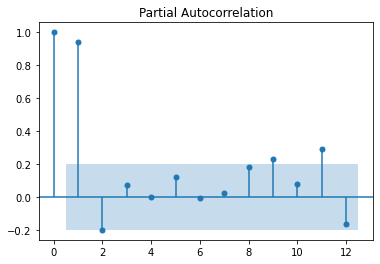

In [47]:
# Pacf plot
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_pacf(airlines_new.Passengers,lags=12)
plt.show()
# Lag 1 has not show change in both plot so can take lag =1 

# Data Splitting 

In [34]:
Train = airlines_new.head(84)
Test = airlines_new.tail(12)
# Taking 1 year data for test 

# Linear Models

In [35]:
import statsmodels.formula.api as smf 

In [36]:
# Linear Model 
linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
rmse_linear

53.19923653480265

In [92]:
Exp = smf.ols('log_value~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

46.05736110315619

In [39]:
add_sea_Quad = smf.ols('Passengers~t+t-squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

35.34895688467295

In [41]:
Mul_Add_sea = smf.ols('log_value~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

10.519172544323185

# ARIMA

In [61]:
from statsmodels.tsa.arima_model import ARIMA

In [79]:
airlines_data = pd.read_excel('F:\\PYTHON\\DATA SCIENCE\\Forcasting Methods\\Assigments\\Airlines+Data.xlsx', index_col=0,parse_dates=True,squeeze=True)

In [80]:
airlines_data

Month
1995-01-01    112
1995-02-01    118
1995-03-01    132
1995-04-01    129
1995-05-01    121
             ... 
2002-08-01    405
2002-09-01    355
2002-10-01    306
2002-11-01    271
2002-12-01    306
Name: Passengers, Length: 96, dtype: int64

In [81]:
train = airlines_data.head(84)
test = airlines_data.head(12)

In [82]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.715)
train, test = X[0:train_size], X[train_size:]

In [83]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)


>Predicted=201.000, Expected=204.000
>Predicted=204.000, Expected=188.000
>Predicted=188.000, Expected=235.000
>Predicted=235.000, Expected=227.000
>Predicted=227.000, Expected=234.000
>Predicted=234.000, Expected=264.000
>Predicted=264.000, Expected=302.000
>Predicted=302.000, Expected=293.000
>Predicted=293.000, Expected=259.000
>Predicted=259.000, Expected=229.000
>Predicted=229.000, Expected=203.000
>Predicted=203.000, Expected=229.000
>Predicted=229.000, Expected=242.000
>Predicted=242.000, Expected=233.000
>Predicted=233.000, Expected=267.000
>Predicted=267.000, Expected=269.000
>Predicted=269.000, Expected=270.000
>Predicted=270.000, Expected=315.000
>Predicted=315.000, Expected=364.000
>Predicted=364.000, Expected=347.000
>Predicted=347.000, Expected=312.000
>Predicted=312.000, Expected=274.000
>Predicted=274.000, Expected=237.000
>Predicted=237.000, Expected=278.000
RMSE: 29.058


In [84]:
series  = pd.read_excel('F:\\PYTHON\\DATA SCIENCE\\Forcasting Methods\\Assigments\\Airlines+Data.xlsx', index_col=0,parse_dates=True,squeeze=True)

In [85]:
# separate out a validation dataset
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 84, Validation 12


In [86]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.715)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [89]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [90]:
# load dataset
train = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=87.974
ARIMA(0, 0, 1) RMSE=49.107
ARIMA(0, 1, 0) RMSE=29.116
ARIMA(0, 1, 1) RMSE=28.328
ARIMA(0, 1, 2) RMSE=30.666
ARIMA(0, 1, 3) RMSE=26.562
ARIMA(0, 1, 4) RMSE=24.650
ARIMA(0, 2, 0) RMSE=35.791
ARIMA(0, 2, 1) RMSE=29.844
ARIMA(0, 2, 2) RMSE=28.876
ARIMA(0, 2, 3) RMSE=29.171
ARIMA(0, 2, 4) RMSE=27.485
ARIMA(1, 0, 0) RMSE=29.596
ARIMA(1, 0, 1) RMSE=28.465
ARIMA(1, 0, 2) RMSE=44.782
ARIMA(1, 0, 4) RMSE=180.396
ARIMA(1, 1, 0) RMSE=28.830
ARIMA(1, 1, 1) RMSE=27.792
ARIMA(1, 1, 2) RMSE=25.304
ARIMA(1, 2, 0) RMSE=35.272
ARIMA(2, 0, 0) RMSE=29.093
ARIMA(2, 1, 0) RMSE=28.255
ARIMA(2, 1, 1) RMSE=25.236
ARIMA(2, 2, 0) RMSE=33.534
ARIMA(3, 0, 0) RMSE=28.707
ARIMA(3, 0, 1) RMSE=28.653
ARIMA(3, 1, 0) RMSE=28.832
ARIMA(3, 1, 1) RMSE=25.625
ARIMA(3, 2, 0) RMSE=34.396
ARIMA(4, 0, 0) RMSE=29.279
ARIMA(4, 1, 0) RMSE=27.755
ARIMA(4, 1, 1) RMSE=26.573
ARIMA(4, 2, 0) RMSE=32.502
ARIMA(4, 2, 1) RMSE=28.361
Best ARIMA(0, 1, 4) RMSE=24.650


In [109]:
rmse_ARIMA_model = 24.650

# Combine train and test data and build final model

In [96]:
X = airlines_data.values
X = X.astype('float32')

In [97]:
model = ARIMA(X, order=(0,1,4))
model_fit = model.fit()

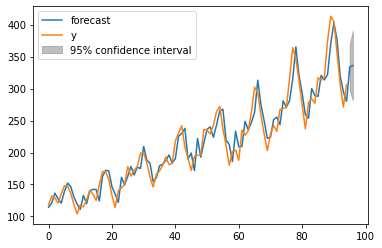

<Figure size 720x504 with 0 Axes>

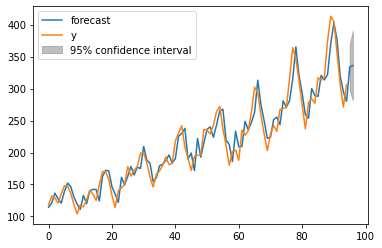

In [99]:
plt.figure(figsize=(10,7))
forecast=model_fit.forecast(steps=12)[0]
model_fit.plot_predict(1,97)

In [100]:
forecast

array([333.64541919, 338.10562304, 344.47641649, 334.99092844,
       337.34158488, 339.69224132, 342.04289776, 344.39355419,
       346.74421063, 349.09486707, 351.44552351, 353.79617994])

In [110]:
list = [['Linear model ',rmse_linear], ['Exponential model',rmse_Exp],
          ['quad add sea',rmse_add_sea_quad],['mult sea',rmse_Mult_add_sea],
           ['ARIMA Model', rmse_ARIMA_model]]

In [111]:
df = pd.DataFrame(list, columns =['Model', 'RMSE_Value']) 
df

,Model,RMSE_Value
0,Linear model,53.199237
1,Exponential model,46.057361
2,quad add sea,35.348957
3,mult sea,10.519173
4,ARIMA Model,24.650000


In [ ]:
# Multiplicative seasonality having best RMSE

In [112]:
Final_model = smf.ols('log_value~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = Train).fit()
final_pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))


In [114]:
np.exp(final_pred_Mult_add_sea)

84    279.259237
85    283.647937
86    327.699745
87    316.197279
88    313.139118
89    352.485470
90    392.396393
91    392.543731
92    352.653113
93    310.444392
94    272.127554
95    312.614872
dtype: float64